<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['alicia-keys.txt',
 'blink-182.txt',
 'bjork.txt',
 'michael-jackson.txt',
 'notorious-big.txt',
 'britney-spears.txt',
 'bruno-mars.txt',
 'Lil_Wayne.txt',
 'dickinson.txt',
 'radiohead.txt',
 'drake.txt',
 'johnny-cash.txt',
 'nirvana.txt',
 'lady-gaga.txt',
 'ludacris.txt',
 'amy-winehouse.txt',
 'patti-smith.txt',
 'kanye-west.txt',
 'nicki-minaj.txt',
 'kanye.txt',
 'rihanna.txt',
 'eminem.txt',
 'disney.txt',
 'cake.txt',
 'bob-marley.txt',
 'dj-khaled.txt',
 'dr-seuss.txt',
 'lorde.txt',
 'leonard-cohen.txt',
 'Kanye_West.txt',
 'bruce-springsteen.txt',
 'bieber.txt',
 'nursery_rhymes.txt',
 'joni-mitchell.txt',
 'lin-manuel-miranda.txt',
 'adele.txt',
 'r-kelly.txt',
 'nickelback.txt',
 'janisjoplin.txt',
 'jimi-hendrix.txt',
 'missy-elliott.txt',
 'paul-simon.txt',
 'dolly-parton.txt',
 'al-green.txt',
 'beatles.txt',
 'notorious_big.txt',
 'bob-dylan.txt',
 'prince.txt',
 'lil-wayne.txt']

In [4]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/nirvana.txt', sep='/n', header=None)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,"Load up on guns, bring your friends"
1,It's fun to lose and to pretend
2,She's over-bored and self-assured
3,"Oh no, I know a dirty word Hello, hello, hello..."
4,"Hello, hello, hello, how low"


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1985


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [7]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Load up on guns, bring your friends'

In [8]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['load', 'up', 'on', 'guns', 'bring', 'your', 'friends']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [9]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [10]:
# Demos un vistazo
sentence_tokens[:2]

[['load', 'up', 'on', 'guns', 'bring', 'your', 'friends'],
 ["it's", 'fun', 'to', 'lose', 'and', 'to', 'pretend']]

In [11]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [12]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['load', 'up', 'on', 'guns'],
 ['up', 'on', 'guns', 'bring'],
 ['on', 'guns', 'bring', 'your']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [13]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [14]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[5, 3, 1, 2], [3, 1, 2, 4], [1, 2, 4, 6]]

In [15]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

3


In [16]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

6


In [17]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'on': 1, 'guns': 2, 'up': 3, 'bring': 4, 'load': 5, 'your': 6}


In [18]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'on': 3, 'up': 2, 'load': 1, 'guns': 3, 'bring': 2, 'your': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [19]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                   Load up on guns, bring your friends
1                       It's fun to lose and to pretend
2                     She's over-bored and self-assured
3     Oh no, I know a dirty word Hello, hello, hello...
4                          Hello, hello, hello, how low
5                          Hello, hello, hello, how low
6     Hello, hello, hello With the lights out, it's ...
7                         Here we are now, entertain us
8                          I feel stupid and contagious
9                         Here we are now, entertain us
10          A mulatto, an albino, a mosquito, my libido
11                Yeah, hey I'm worse at what I do best
12                     And for this gift I feel blessed
13                     Our little group has always been
14    And always will until the end Hello, hello, he...
15                         Hello, hello, hello, how low
Name: 0, dtype: object

In [20]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Load up on guns, bring your friends It\'s fun to lose and to pretend She\'s over-bored and self-assured Oh no, I know a dirty word Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello With the lights out, it\'s less dangerous Here we are now, entertain us I feel stupid and contagious Here we are now, entertain us A mulatto, an albino, a mosquito, my libido Yeah, hey I\'m worse at what I do best And for this gift I feel blessed Our little group has always been And always will until the end Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello With the lights out, it\'s less dangerous Here we are now, entertain us I feel stupid and contagious Here we are now, entertain us A mulatto, an albino, a mosquito, my libido Yeah, hey, yeh And I forget just why I taste Oh yeah, I guess it makes me smile I found it hard, it\'s hard to find Oh well, whatever, never mind Hello, hello, hello, ho

In [21]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['load',
 'up',
 'on',
 'guns',
 'bring',
 'your',
 'friends',
 "it's",
 'fun',
 'to',
 'lose',
 'and',
 'to',
 'pretend',
 "she's",
 'over',
 'bored',
 'and',
 'self',
 'assured']

In [22]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 12346


In [23]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [24]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['load', 'up', 'on', 'guns'],
 ['up', 'on', 'guns', 'bring'],
 ['on', 'guns', 'bring', 'your'],
 ['guns', 'bring', 'your', 'friends'],
 ['bring', 'your', 'friends', "it's"],
 ['your', 'friends', "it's", 'fun'],
 ['friends', "it's", 'fun', 'to'],
 ["it's", 'fun', 'to', 'lose'],
 ['fun', 'to', 'lose', 'and'],
 ['to', 'lose', 'and', 'to'],
 ['lose', 'and', 'to', 'pretend'],
 ['and', 'to', 'pretend', "she's"],
 ['to', 'pretend', "she's", 'over'],
 ['pretend', "she's", 'over', 'bored'],
 ["she's", 'over', 'bored', 'and'],
 ['over', 'bored', 'and', 'self'],
 ['bored', 'and', 'self', 'assured'],
 ['and', 'self', 'assured', 'oh'],
 ['self', 'assured', 'oh', 'no'],
 ['assured', 'oh', 'no', 'i']]

In [25]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[617, 74, 26, 472],
 [74, 26, 472, 382],
 [26, 472, 382, 18],
 [472, 382, 18, 220],
 [382, 18, 220, 33],
 [18, 220, 33, 272],
 [220, 33, 272, 5],
 [33, 272, 5, 244],
 [272, 5, 244, 7],
 [5, 244, 7, 5],
 [244, 7, 5, 342],
 [7, 5, 342, 343],
 [5, 342, 343, 221],
 [342, 343, 221, 383],
 [343, 221, 383, 7],
 [221, 383, 7, 384],
 [383, 7, 384, 473],
 [7, 384, 473, 124],
 [384, 473, 124, 15],
 [473, 124, 15, 1]]

In [26]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 12342


### 3 - Input y target

In [27]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [28]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [29]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [30]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(12342, 3)
(12342,)


In [31]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'the',
 3: 'a',
 4: 'you',
 5: 'to',
 6: 'me',
 7: 'and',
 8: "don't",
 9: 'in',
 10: 'my',
 11: "i'm",
 12: 'it',
 13: 'of',
 14: 'hello',
 15: 'no',
 16: 'is',
 17: 'have',
 18: 'your',
 19: 'know',
 20: "you're",
 21: 'for',
 22: 'girl',
 23: 'she',
 24: 'what',
 25: 'they',
 26: 'on',
 27: 'with',
 28: 'like',
 29: 'not',
 30: 'way',
 31: 'we',
 32: 'was',
 33: "it's",
 34: 'when',
 35: 'away',
 36: 'yeah',
 37: 'this',
 38: 'as',
 39: 'expect',
 40: 'do',
 41: 'be',
 42: 'never',
 43: 'so',
 44: 'if',
 45: 'out',
 46: 'love',
 47: 'more',
 48: 'all',
 49: 'right',
 50: 'think',
 51: 'will',
 52: 'just',
 53: 'are',
 54: 'said',
 55: 'feel',
 56: 'one',
 57: 'gun',
 58: 'can',
 59: "ain't",
 60: 'dive',
 61: 'find',
 62: 'that',
 63: 'sun',
 64: 'had',
 65: 'here',
 66: 'now',
 67: 'little',
 68: 'her',
 69: 'would',
 70: 'night',
 71: 'go',
 72: 'gonna',
 73: 'take',
 74: 'up',
 75: 'how',
 76: 'hey',
 77: "i've",
 78: 'he',
 79: 'ah',
 80: 'heart',
 81: 'but',
 82: '

In [32]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1479

In [33]:
# Transformar los datos a oneHotEncoding
#y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [34]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [35]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(12342, 1479)

### 4 - Entrenar el modelo

In [36]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [37]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1479

In [38]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              7400      
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1479)              48807     
                                                                 
Total params: 109,231
Trainable params: 109,231
Non-trai

In [39]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
309/309 [==============================] - 7s 10ms/step - loss: 6.1638 - accuracy: 0.0411 - val_loss: 6.6769 - val_accuracy: 0.0312
Epoch 2/50
309/309 [==============================] - 2s 7ms/step - loss: 5.7340 - accuracy: 0.0411 - val_loss: 6.9387 - val_accuracy: 0.0312
Epoch 3/50
309/309 [==============================] - 2s 7ms/step - loss: 5.6853 - accuracy: 0.0430 - val_loss: 7.1295 - val_accuracy: 0.0312
Epoch 4/50
309/309 [==============================] - 2s 7ms/step - loss: 5.6575 - accuracy: 0.0451 - val_loss: 7.2798 - val_accuracy: 0.0312
Epoch 5/50
309/309 [==============================] - 2s 7ms/step - loss: 5.6269 - accuracy: 0.0468 - val_loss: 7.4050 - val_accuracy: 0.0304
Epoch 6/50
309/309 [==============================] - 2s 7ms/step - loss: 5.5783 - accuracy: 0.0514 - val_loss: 7.3592 - val_accuracy: 0.0316
Epoch 7/50
309/309 [==============================] - 2s 7ms/step - loss: 5.4921 - accuracy: 0.0561 - val_loss: 7.6185 - val_accuracy: 0.0344
Epoch

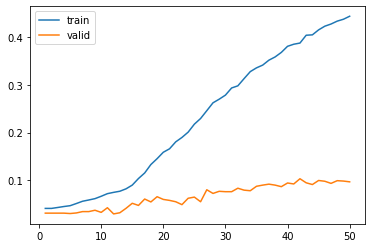

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Entrenar el modelo con Bidirectional RNN

In [41]:
from keras.layers import Bidirectional

model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

#model2 = Sequential()
#model2.add(Bidirectional(LSTM(64, activation='relu'), input_shape=input_shape))
#model2.add(Dense(output_shape))
#model2.compile(loss='mse',
#              optimizer="Adam")

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64))) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              7400      
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1479)              48807     
                                                      

In [42]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
309/309 [==============================] - 8s 12ms/step - loss: 6.1524 - accuracy: 0.0393 - val_loss: 6.7996 - val_accuracy: 0.0312
Epoch 2/50
309/309 [==============================] - 3s 8ms/step - loss: 5.7314 - accuracy: 0.0444 - val_loss: 6.8894 - val_accuracy: 0.0312
Epoch 3/50
309/309 [==============================] - 3s 8ms/step - loss: 5.6775 - accuracy: 0.0436 - val_loss: 7.1233 - val_accuracy: 0.0312
Epoch 4/50
309/309 [==============================] - 3s 8ms/step - loss: 5.6348 - accuracy: 0.0440 - val_loss: 7.0413 - val_accuracy: 0.0312
Epoch 5/50
309/309 [==============================] - 3s 8ms/step - loss: 5.5288 - accuracy: 0.0441 - val_loss: 7.3200 - val_accuracy: 0.0312
Epoch 6/50
309/309 [==============================] - 3s 8ms/step - loss: 5.3863 - accuracy: 0.0514 - val_loss: 7.4402 - val_accuracy: 0.0316
Epoch 7/50
309/309 [==============================] - 3s 8ms/step - loss: 5.2380 - accuracy: 0.0598 - val_loss: 7.6678 - val_accuracy: 0.0344
Epoch

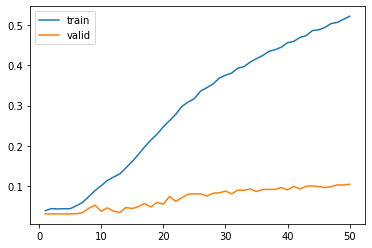

In [43]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 6 - Entrenar el modelo con Bidirectional RNN, mas neuronas y mas epochs

In [44]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128))) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              7400      
                                                                 
 lstm_4 (LSTM)               (None, 3, 128)            68608     
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dense_5 (Dense)             (None, 1479)              48807     
                                                      

In [45]:
hist = model.fit(x_data, y_data, epochs=200, validation_split=0.2)

Epoch 1/200
309/309 [==============================] - 8s 12ms/step - loss: 6.1230 - accuracy: 0.0412 - val_loss: 6.7705 - val_accuracy: 0.0312
Epoch 2/200
309/309 [==============================] - 3s 9ms/step - loss: 5.7366 - accuracy: 0.0421 - val_loss: 6.9676 - val_accuracy: 0.0312
Epoch 3/200
309/309 [==============================] - 3s 9ms/step - loss: 5.6794 - accuracy: 0.0414 - val_loss: 7.0503 - val_accuracy: 0.0312
Epoch 4/200
309/309 [==============================] - 3s 9ms/step - loss: 5.5834 - accuracy: 0.0521 - val_loss: 7.1933 - val_accuracy: 0.0348
Epoch 5/200
309/309 [==============================] - 3s 9ms/step - loss: 5.3729 - accuracy: 0.0615 - val_loss: 7.3777 - val_accuracy: 0.0385
Epoch 6/200
309/309 [==============================] - 3s 9ms/step - loss: 5.0948 - accuracy: 0.0759 - val_loss: 7.5341 - val_accuracy: 0.0450
Epoch 7/200
309/309 [==============================] - 3s 9ms/step - loss: 4.7957 - accuracy: 0.0944 - val_loss: 8.0578 - val_accuracy: 0.047

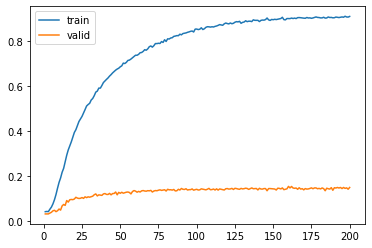

In [46]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 7 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [47]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 5.6 MB 5.1 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 212 kB 74.4 MB/s 
     |████████████████████████████████| 272 kB 63.0 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 141 kB 70.9 MB/s 
     |████████████████████████████████| 2.3 MB 46.1 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 57 kB 6.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 10.9 MB/s 
     |████████████████████████████████| 68 kB 7.6 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 4.1 MB 46.3 MB/s 
     |████████████████████████████████| 856 kB 72.0 MB/s 


In [48]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://34095.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7feea27ab310>,
 'http://127.0.0.1:7860/',
 'https://34095.gradio.app')

### 8 - Generación de secuencias nuevas

In [49]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [51]:
input_text='hello'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

'hello to is'

### 9 - Resumen

Se eligió el dataset de canciones de Nirvana ("nirvana.txt") para crear embeddings propios de palabras basado en el contexto que ofrece el dataset. Estos embeddings se utilizaron en diferentes arquitecturas para predecir la próxima posible palabra.

La arquitectura base que se empleó fue la del script estudiado en clase, con layers LSTM. El modelo entrenado no tuvo un desempeño correcto, además hay overfitting (ver accuracy de validación).

Para tratar de mejorar el modelo, se utlizó una capa LSTM bidireccional. A pesar de que el entrenamiento logró una mejor accuracy, la de validación fue similar al modelo base.

Por último, se probó el modelo anterior pero aumentando al doble el número de neuronas de las 2 capas hidden durante 200 epochs. Nuevamente el entrenamiento mejora pero la validación se mantiene en los valores de los modelos previos.

Empleando el modelo final y, mediante *gradio*, se ensayó la predicción de la siguiente palabra. Como era de esperarse, los resultados no fueron los mejores.

Estos resultados no tan buenos se deben a que entrenamos los embeddings a partir de un dataset pequeño. Para obtener un buen resultado se debería entrenar los embeddings a partir de datasets considerablemente más grandes, o bien, utilizar embeddings pre-enternados.